#  Step 1: Exploratory Data Analysis & Data Audit  　
**Objective:** To assess data quality, identify compliance risks (fairness), detect data leakage, and formulate a robust preprocessing strategy.


## 0. Setup and Configuration

Install and import all dependencies used below. You can comment out the `pip install` lines if your environment already has them.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set professional plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Explicitly set Pandas display options to avoid column truncation
pd.set_option('display.max_columns', None)

## 1. Data Loading

In [23]:
df = pd.read_csv("../data/raw/dataproject2025.csv")

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1086236, 39)


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,fico_range_high,funded_amnt,grade,home_ownership,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,759.0,4800.0,B,MORTGAGE,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,734.0,27050.0,B,OWN,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,749.0,28000.0,A,MORTGAGE,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,719.0,12000.0,B,MORTGAGE,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,669.0,27600.0,D,MORTGAGE,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 39 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   Unnamed: 0               1086236 non-null  int64  
 1   issue_d                  1086236 non-null  int64  
 2   loan duration            1086236 non-null  int64  
 3   annual_inc               1086236 non-null  float64
 4   avg_cur_bal              1086236 non-null  float64
 5   bc_open_to_buy           1086236 non-null  float64
 6   bc_util                  1086236 non-null  float64
 7   delinq_2yrs              1086236 non-null  float64
 8   dti                      1086236 non-null  float64
 9   emp_length               1086236 non-null  object 
 10  emp_title                1086236 non-null  object 
 11  fico_range_high          1086236 non-null  float64
 12  funded_amnt              1086236 non-null  float64
 13  grade                    1086236 non-null 

## 2.Business Context (Default Rate: 21.05%)

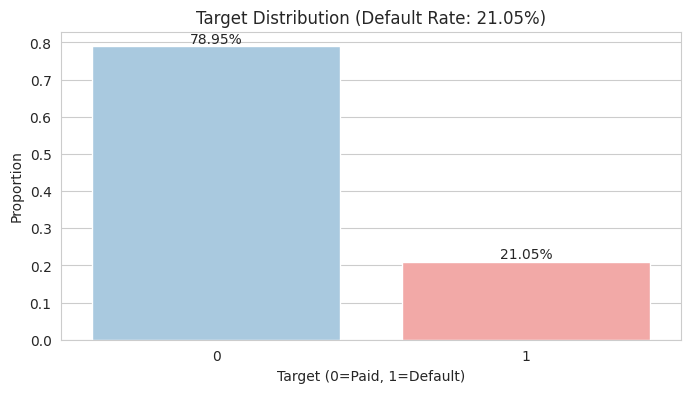

In [26]:
# Default Rate
target_counts = df['target'].value_counts(normalize=True)
default_rate = target_counts[1]

# Graph
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=['#A0CBE8', '#FF9D9A'])
plt.title(f"Target Distribution (Default Rate: {default_rate:.2%})")
plt.xlabel("Target (0=Paid, 1=Default)")
plt.ylabel("Proportion")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
plt.show()

## 3. Data Leakage Audit

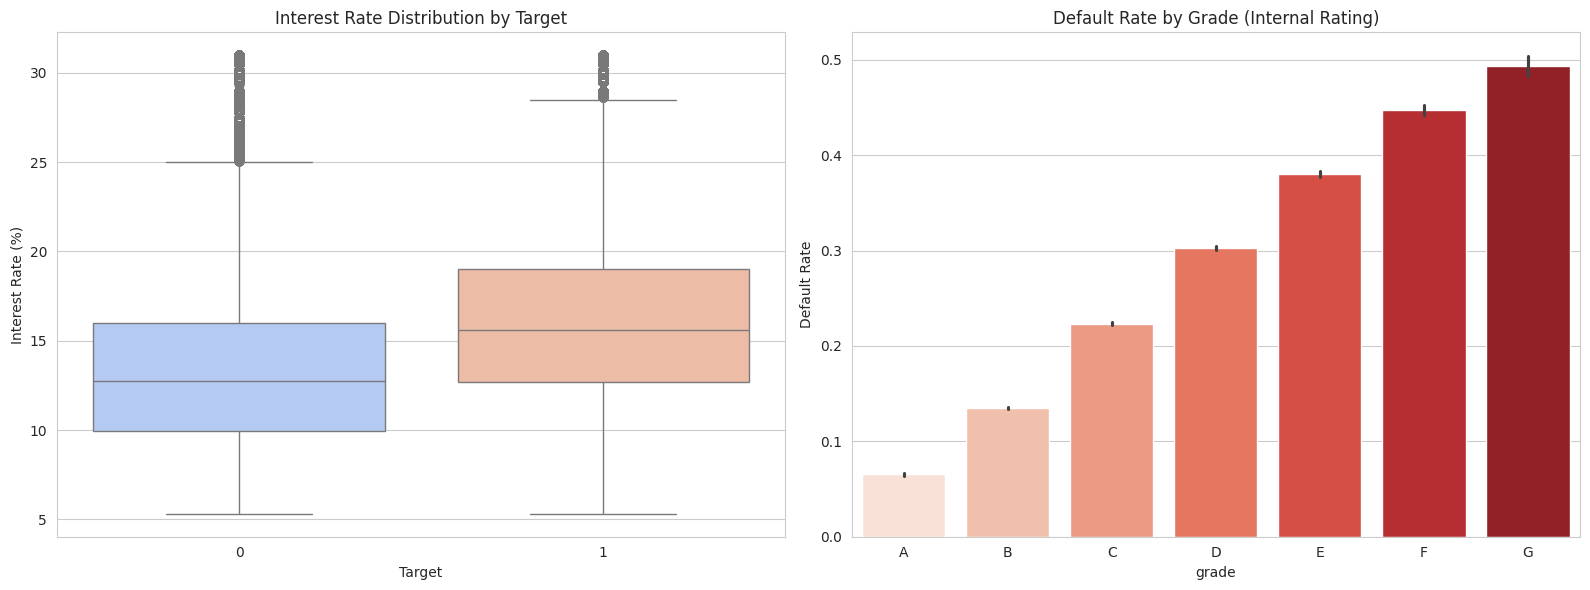

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Interest Rate vs Default Rate
sns.boxplot(data=df, x='target', y='int_rate', ax=axes[0], palette='coolwarm')
axes[0].set_title("Interest Rate Distribution by Target")
axes[0].set_xlabel("Target")
axes[0].set_ylabel("Interest Rate (%)")

# 2. Grade vs Default Rate
# Grade sorted important!
grade_order = sorted(df['grade'].unique())
sns.barplot(data=df, x='grade', y='target', order=grade_order, ax=axes[1], palette='Reds')
axes[1].set_title("Default Rate by Grade (Internal Rating)")
axes[1].set_ylabel("Default Rate")

plt.tight_layout()
plt.show()

The chart shows that `grade` and `int_rate` are highly correlated with default. This is because they are risk attributes assigned by the bank after loan approval. Using them in a predictive model would constitute **data leakage**.  

**Strategy:** These features must be excluded during the training phase.


## 4. Fairness Audit

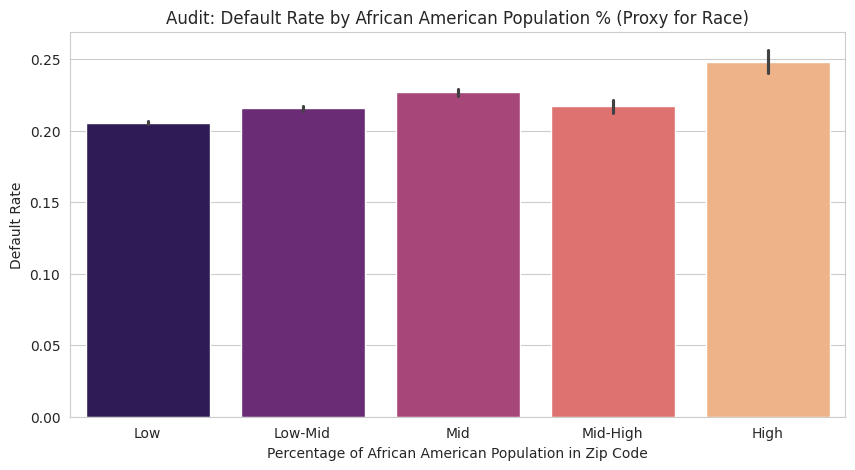

In [32]:
# Check Proxy Variables
df['ethnicity_bin'] = pd.cut(df['Pct_afro_american'], bins=5, labels=['Low', 'Low-Mid', 'Mid', 'Mid-High', 'High'])

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='ethnicity_bin', y='target', palette="magma")
plt.title("Audit: Default Rate by African American Population % (Proxy for Race)")
plt.xlabel("Percentage of African American Population in Zip Code")
plt.ylabel("Default Rate")
plt.show()

The data shows that areas with a higher proportion of African-American population have higher default rates. If we keep `zip_code` or `Pct_afro_american`, the model would inevitably learn racial biases, leading to **redlining**, which violates the **ECOA** (Equal Credit Opportunity Act).  

**Strategy:** For compliance reasons, these features must be excluded.


## 5. Temporal Stability

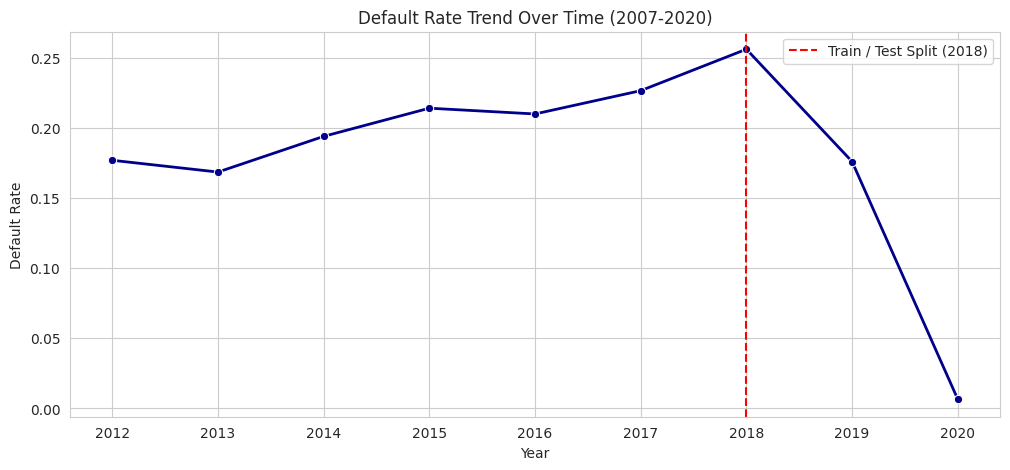

In [ ]:
default_by_year = df.groupby('issue_d')['target'].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=default_by_year.index, y=default_by_year.values, marker='o', linewidth=2, color='darkblue')
plt.title("Default Rate Trend Over Time (2007-2020)")
plt.axvline(x=2018, color='red', linestyle='--', label='Train / Test Split (2018)')
plt.ylabel("Default Rate")
plt.xlabel("Year")
plt.legend()
plt.show()

The default rate fluctuates over time, but there are no drastic structural breaks. Using 2018-2020 as the **test set** is reasonable, as it can simulate a real-world **forecasting** scenario.


## 6. Data Cleaning and Feature Preprocessing

In [34]:
# 1. Transform emp_length (String -> Numeric)
def parse_emp_length(x):
    x = str(x)
    if '< 1' in x: return 0
    if '10+' in x: return 10
    # take out number "2 years" -> 2
    try:
        return int(x.split()[0])
    except:
        return 0 # Fallback

df['emp_length_num'] = df['emp_length'].apply(parse_emp_length)

# 2. Feature Blacklist
COLS_TO_DROP = [
    # A. Cheating Features
    'Predictions', 'Predicted probabilities',
    
    # B. Data Leakage
    'grade', 'sub_grade', 'int_rate',
    
    # C. Compliance Risks
    'zip_code', 'Pct_afro_american',
    
    # D. Redundant/Raw Features
    'emp_length', 'emp_title', 'issue_d', 'Unnamed: 0'
]

# Final train features
final_features = [c for c in df.columns if c not in COLS_TO_DROP and c != 'target']

print("❌ Dropping Columns:", COLS_TO_DROP)
print(f"✅ Final Feature Count: {len(final_features)}")

❌ Dropping Columns: ['Predictions', 'Predicted probabilities', 'grade', 'sub_grade', 'int_rate', 'zip_code', 'Pct_afro_american', 'emp_length', 'emp_title', 'issue_d', 'Unnamed: 0']
✅ Final Feature Count: 29


### 🚀 Executive Summary & Next Steps

Based on our Data Audit, we have established the following **Modeling Strategy**:

1.  **Integrity:** Removed synthetic prediction columns to prevent target leakage.
2.  **Compliance:** Excluded `zip_code` and ethnicity features to ensure **Fairness by Design**.
3.  **Robustness:** Excluded `grade` and `int_rate` to build a standalone risk model independent of legacy internal ratings.
4.  **Imputation:** While the current dataset appears pre-filled, we parsed `emp_length` to preserve ordinality.

**Next Step:** Proceed to **Model Tournament** (XGBoost vs. CatBoost) using the cleaned feature set.